# Defining QoIs and running the MITgcm adjoint model to obtain adjoint sensitivity matrices

The process of differentiating and compiling MITgcm to obtain its adjoint, as well as running the compiled adjoint with generic QoIs, is described in `ECCO_adjoint_instructions.pdf` Section 3.
Our adjoint experiments use a CORE normal year forced version of the ECCOv4r4 configuration. Forcing, restart, and namelist files specific to this version can be found at https://doi.org/10.5281/zenodo.7814839

In order to define the QoI in a way that can be read by the adjoint, we need to edit the `data.ecco` namelist file, telling it which type of QoI we are interested in. We also need to provide masks in binary MDS format to tell the model where and when to evaluate the QoI. This is described in more detail [in the MITgcm manual](https://mitgcm.readthedocs.io/en/latest/ocean_state_est/ocean_state_est.html#generic-cost-function), as well as Section 3.1.2 of `ECCO_adjoint_instructions.pdf`.

This notebook defines space and time masks and provides the `data.ecco` file common to each QoI. A function is defined that takes a latitude, maximum depth, and time-averaging parameters, then writes MDS mask files of the corresponding AMOC volume transport QoI. The function is called for each of the 4 latitudes in our study. The max depth in each case is the local depth of maximum climatological overturning (calculation not shown).

In [ ]:
from DPC_functions import *

In [97]:
def make_AMOC_MVT_mask(lat,depth,runperiods,qoiperiods,preview=True):
    '''
    Make MDS files corresponding to an AMOC volume transport QoI, to be read by the data.ecco namelist
    
    Parameters:
    -----------
    lat (np.float64):     the latitude at which to evaluate the AMOC. The function calculates the nearest
                          indices on the LLC90 grid and defines the QoI there.
    depth (np.float64):   the depth of integration of the volume transport. Any grid cells deeper are masked.
    runperiods (int):     The number of "periods" in the adjoint model run. The type of period is defined in
                          data.ecco, for instance "month". To run the model for a year then corresponds to 
                          runperiods=12.
    qoiperiods (int):     The number of "periods" over which to average the QoI. For instance, for a ten year
                          run with period type "month" and annual-average QoI, runperiods=120, qoiperiods=12.
    preview 
    (bool, default=True): show a preview of the generated masks, one figure per mask.
    
    Returns:
    --------
    MASKS 
    (xarray.DataArray): The "S" mask (defined on the LLC90 "south" points). Takes values 0 or 1.
    MASKW:
    (xarray.DataArray): The "W" mask (defined on the LLC90 "west" points). Takes values 0 or -1 (to account
                        for direction of north on tiles 7-12)
    MASKK:
    (xarray.DataArray): The "K" mask (defined on the LLC90 "Z" points). Takes values 0 or 1.
    MASKT:
    (np.ndarray)      : The "T" mask, 1 for run periods where the QoI is averaged, 0 elsewhere.
    '''
    ################ 1. Define "S" mask (tiles 0-6)
    ################################################    
    MASKS=ecco.get_basin_mask(basin_name='atl',mask=GDS['hFacS'],less_output=True)
    
    ## Find nearest index to chosen latitude
    # Determine the meridional distance from each meridional velocity point to the target latitude
    latdstS=np.abs(GDS['YG'].values-lat)
    
    # Arrange all 6 "North-is-up" LLC90 tiles of the distance array next to each other,
    #    get the row index of the minimum distance on this new array (for each column),
    #    the index for each column should be the same, so pick this unique value and convert to int
    latidxS=int(np.unique(np.argmin(\
              np.hstack([np.vstack(latdstS[0:3,:]),\
                         np.vstack(latdstS[3:6,:])])\
                                   ,axis=0)))
    
    # Convert the index on the re-arranged 6-tile array back to a tile index and a j index
    tileidsS=[latidxS//90  ,latidxS//90 +  3]
    jidx    = latidxS%90

    tmpmskS=xr.zeros_like(basmskS)
    tmpmskS[:,tileidsS,jidx,:]=1

    MASKS=MASKS*tmpmskS
    
    ################ 2. Define "W" mask (tiles 7-12)
    ################################################
    MASKW=ecco.get_basin_mask(basin_name='atl',mask=GDS['hFacW'],less_output=True)
    
    # Array of distances to target latitude
    latdstW=np.abs(GDS['YG'].values-lat)

    ##  Find nearest index to chosen latitude:
    # Arrange all 6 "East-is-up" LLC90 tiles of the distance array next to each other,
    #    get the row index of the minimum distance on this new array (for each column),
    #    the index for each column should be the same, so pick this unique value and convert to int    
    
    latidxW=int(np.unique(np.argmin(\
              np.vstack([np.hstack(latdstW[ 7:10,:]),\
                         np.hstack(latdstW[10:13,:])])\
                                   ,axis=1)))
    # Convert the index on the re-arranged 6-tile array back to a tile index and an i index
    tileidsW=[latidxW//90+7,latidxW//90 + 10]
    iidx    = latidxW%90
    
    tmpmskW=xr.zeros_like(basmskW);
    # Set to -1 on the W grid (+ve is southward)
    tmpmskW[:,tileidsW,:,iidx]=-1

    MASKW=MASKW*tmpmskW

    ################ 3. Define "K" mask
    ################################################
    
    MASKS=MASKS.where(GDS['Z']       >-dep,0)
    MASKW=MASKW.where(GDS['Z']       >-dep,0)
    
    MASKK =xr.ones_like(GDS['Z']).where(GDS['Z']>-dep,0)

    ################ 4. Define time mask
    ################################################
    MASKT=np.zeros(runperiods)
    MASKT[        -qoiperiods:]=1

    ################ 5. show optional preview
    ################################################

    if preview:
        plt.figure()
        ecco.plot_proj_to_latlon_grid(GDS.XC,GDS.YG,MASKS.isel(k=0),cmin=-1,cmax=1,cmap='bwr');
        plt.title('MASKS')
        plt.gcf().set_size_inches(12,5)
        plt.figure()
        ecco.plot_proj_to_latlon_grid(GDS.XG,GDS.YC,MASKW.isel(k=0),cmin=-1,cmax=1,cmap='bwr');
        plt.title('MASKW')
        plt.gcf().set_size_inches(12,5)
        plt.figure()
        plt.plot(MASKK,GDS['Z'],'kx')
        plt.xlim(0,1);plt.ylim(-6000,0)
        plt.title('MASKK')
        plt.ylabel('Depth (m)')
        plt.xlabel('Mask value')
        plt.figure()
        plt.plot(np.arange(-runperiods,0),MASKT,'kx')
        plt.title('MASKT')
        plt.xlabel('Run period (e.g. day,month)')
        plt.ylabel('Mask value')
        plt.xlim(-runperiods,0)
        plt.ylim(0,1)
    
    ############### 6. Write output to MDS files
    ################################################
    
    extra_metadata=xm.utils.get_extra_metadata(domain='llc',nx=90)
    print('converting to standard LLC layout (5 faces)')
    facetsS=xm.utils.rebuild_llc_facets(MASKS.rename({'tile':'face'}),extra_metadata)
    facetsW=xm.utils.rebuild_llc_facets(MASKW.rename({'tile':'face'}),extra_metadata)
    print('converting to flat vector')
    compactS=xm.utils.llc_facets_3d_spatial_to_compact(facetsS,'k',extra_metadata=extra_metadata)
    compactW=xm.utils.llc_facets_3d_spatial_to_compact(facetsW,'k',extra_metadata=extra_metadata)
    print('writing output')
    xm.utils.write_to_binary(compactS,'MVT'+str(lat)+'_MASKS')
    xm.utils.write_to_binary(compactW,'MVT'+str(lat)+'_MASKW')

    xm.utils.write_to_binary(MASKT,'MVT'+str(lat)+'_MASKT')
    xm.utils.write_to_binary(MASKK.values,'MVT'+str(lat)+'_MASKK')

    #### Write information about QoI to a text file
    with open('MVT'+str(lat)+'_MASK.info','wt') as infofile:
        infostr=('Mask file to be read by ECCO package gencost routines: \n'+\
                 'Basin mask: atl'+'\n'+\
                 'Latitude:  '    +str(lat)+'\n'+\
                 'Depth max: '    +str(dep)+'\n'+\
                 'Run length (periods): '+str(runperiods)+'\n'+\
                 'Periods over which to average QoI: '+str(qoiperiods))
        infofile.write(infostr)
    
    return MASKS,MASKW,MASKK,MASKT

## 25°N, 50-year adjoint run, 10-year average volume transport

converting to standard LLC layout (5 faces)
converting to flat vector
writing output


/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


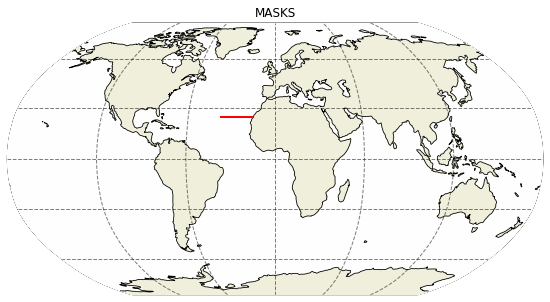

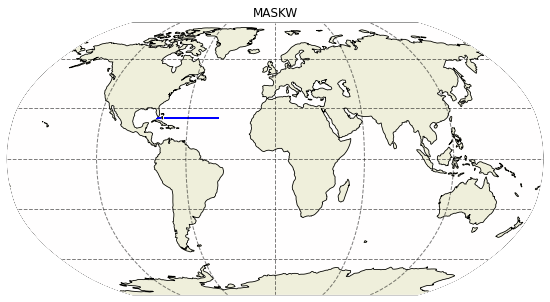

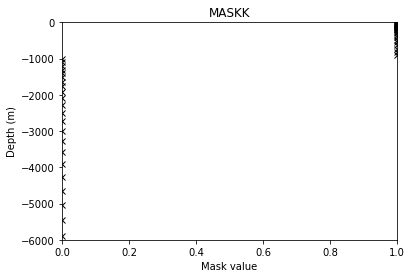

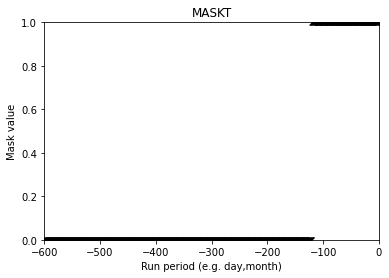

In [98]:
MASKS,MASKW,MASKK,MASKT=make_AMOC_MVT_mask(25,862,12*50,12*10)

## 35°N, 50-year adjoint run, 10-year average volume transport

converting to standard LLC layout (5 faces)
converting to flat vector
writing output


/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


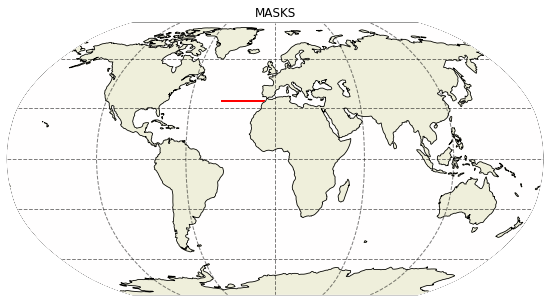

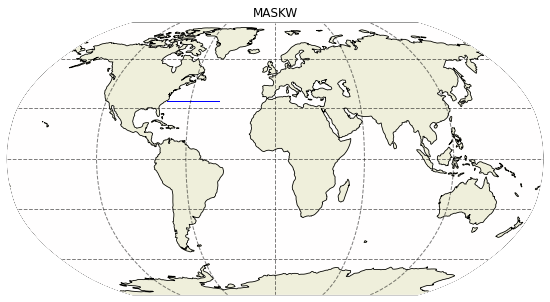

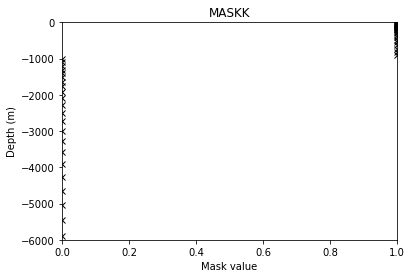

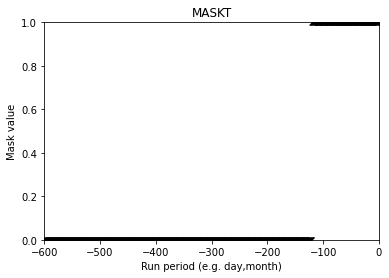

In [99]:
MASKS,MASKW,MASKK,MASKT=make_AMOC_MVT_mask(35,910,12*50,12*10)

## 45°N, 50-year adjoint run, 10-year average volume transport

converting to standard LLC layout (5 faces)
converting to flat vector
writing output


/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


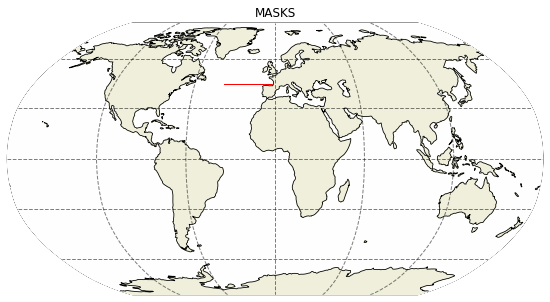

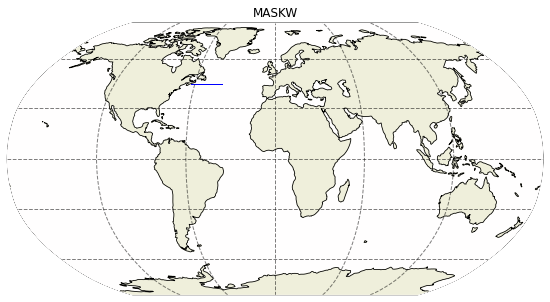

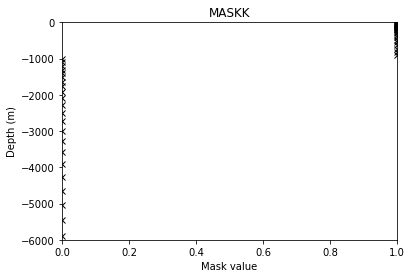

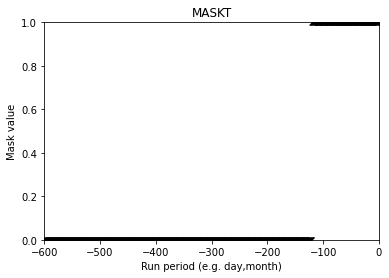

In [100]:
MASKS,MASKW,MASKK,MASKT=make_AMOC_MVT_mask(45,862,12*50,12*10)

## 55°N, 50-year adjoint run, 10-year average volume transport

converting to standard LLC layout (5 faces)
converting to flat vector
writing output


/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/dafydd/miniconda3/envs/oce/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


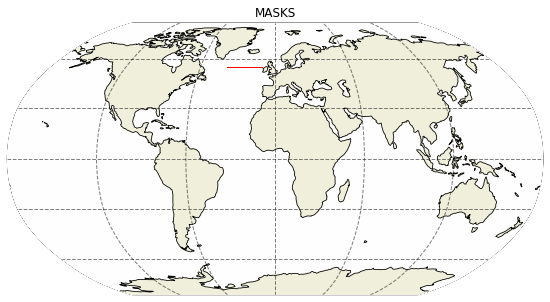

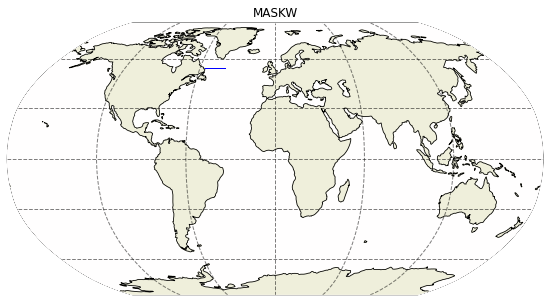

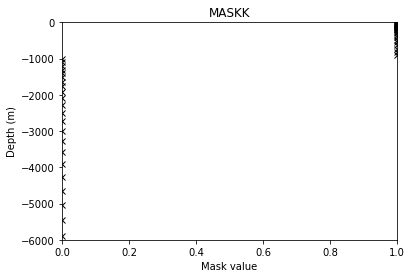

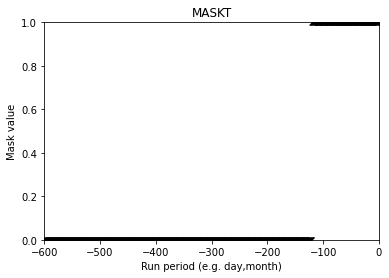

In [101]:
MASKS,MASKW,MASKK,MASKT=make_AMOC_MVT_mask(55,958,12*50,12*10)

# Namelist to run: `data.ecco`
Note, change the line `gencost_mask(1)` in accordance with the latitude of interest:

```
# *******************
# ECCO cost functions
# *******************
 &ECCO_COST_NML
 &
# ***************************
# ECCO generic cost functions (Delete as appropriate)
# ***************************
# Volume transport:
 &ECCO_GENCOST_NML
 gencost_name(1) = 'MVT',
 gencost_barfile(1) = 'm_horflux_vol',
 gencost_avgperiod(1) = 'month',
 gencost_msk_is3d(1)=.TRUE.,
 gencost_outputlevel(1) = 1,
 gencost_mask(1) = 'MVT25_MASK'
 mult_gencost(1) = 1,
#
 &
#

```